# Fetching SDSS images for source classification

This notebook

- makes an SQL query to the SDSS DR12 database (using its [API](http://skyserver.sdss.org/dr12/en/help/docs/api.aspx)) to create a catalog, 
- downloads the FITS files,
- uses [Montage](http://montage.ipac.caltech.edu/) (and [montage wrapper](http://www.astropy.org/montage-wrapper/) to align each image to the image in the $r$-band, and
- uses [Sextractor](http://www.astromatic.net/software/sextractor) to find the pixel position of objects, and
- converts the fluxes in FITS files to [luptitudes](http://www.sdss.org/dr12/algorithms/magnitudes/#asinh).

This [Docker image](https://github.com/EdwardJKim/deeplearning4astro/tree/master/docker) has all packages necessary to run this notebook.

In [6]:
%matplotlib inline
%env PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/Montage/bin

env: PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/Montage/bin


In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import shutil
import requests
import json
import bz2
import re
import subprocess
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import montage_wrapper as mw
from astropy.io import fits
from astropy import wcs

## SQL

For demonstration purposes, we use the SDSS [API](http://skyserver.sdss.org/dr12/en/help/docs/api.aspx) to create an SQL query. However, it's not suitable for making a query with a large number of objects, so the following functions uses only a 1 sq. deg. patch of sky.

[SpecObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecObjAll+U)

[PhotoObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U)

Although there exists a precomputed join ([SpecPhotoAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecPhotoAll+U)) between the PhotoOjbAll and SpecObjAll tables, we do a join ourselves because SpecPhotoAll doesn't have some attributes we want, e.g. the clean photometry flag or the light profiles ("expRad" and "deVRad").

In [3]:
def sample_one_sq_deg(ra, dec, n=500, dr="dr12", timeout=60, d=1):
    
    url = "http://skyserver.sdss.org/SkyserverWS/{}/SearchTools/SqlSearch".format(dr)
    payload = {
        "format": "json",
        "cmd": """
            SELECT TOP {0} spec.specObjID, phot.objID,
                spec.ra, spec.dec,
                spec.class,
                spec.z, spec.zErr,
                phot.rerun, phot.run, phot.camcol, phot.field,
                phot.dered_u, phot.dered_g, phot.dered_r, phot.dered_i, phot.dered_z,
                phot.extinction_u, phot.extinction_g, phot.extinction_r, phot.extinction_i, phot.extinction_z
            FROM SpecObjAll AS spec
            JOIN PhotoObjAll AS phot
            ON spec.specObjID = phot.specObjID
            WHERE
                phot.clean = 1
                AND spec.zWarning = 0
                AND spec.ra >= {1}
                AND spec.ra < {2}
                AND spec.dec >= {3}
                AND spec.dec < {4}
                AND phot.dered_r > 0 and phot.dered_r < 40
                AND phot.expRad_r < 30
                AND phot.deVRad_r < 30
                AND spec.zErr < 0.1
                AND spec.z < 2
                AND spec.class = 'galaxy'
            ORDER BY NEWID()
        """.format(n, ra, ra + d, dec, dec + d).strip()
    }
    
    try:
        resp = requests.post(url, params=payload, timeout=timeout)
    except requests.exceptions.RequestException as e:
        print(e)
        return None

    data = resp.json()[0]['Rows']
    df = pd.DataFrame(data)
    
    df[["specObjID", "objID"]] = df[["specObjID", "objID"]].astype("object")

    return df

For a large number of objects, you can use [CasJobs](http://skyserver.sdss.org/casjobs) as follows.

First, set the CONTEXT tab to DR12, thn submit the following query:
```sql
SELECT spec.specObjID, phot.objID,
    spec.ra, spec.dec,
    spec.class,
    spec.z, spec.zErr,
    phot.rerun, phot.run, phot.camcol, phot.field,
    phot.dered_u, phot.dered_g, phot.dered_r, phot.dered_i, phot.dered_z,
    phot.psfMag_u, phot.psfMag_g, phot.psfMag_r, phot.psfMag_i, phot.psfMag_z,
    cModelMag_u, cModelMag_g, cModelMag_r, cModelMag_i, cModelMag_z
INTO mydb.DR12_spec_phot_all
FROM SpecObjAll AS spec
JOIN PhotoObjAll AS phot
ON spec.specObjID = phot.specObjID
WHERE
    phot.clean = 1
    AND spec.zWarning = 0
    AND phot.dered_r > 0 and phot.dered_r < 40
    AND phot.expRad_r < 30
    AND phot.deVRad_r < 30
    AND spec.zErr < 0.1
    AND spec.z < 2
    AND spec.class = 'galaxy'
```

From this table `mydb.DR12_spec_phot_all`, we randomly choose 100,000 objects:

```sql
SELECT TOP 100000 *
INTO mydb.DR12_spec_phot_sample
FROM mydb.DR12_spec_phot_all
ORDER BY NEWID()
```

In [4]:
df = sample_one_sq_deg(205, 0, d=1, n=50000)

df.to_csv("../data/objects.csv", index=False)

print(df)

     camcol   class       dec   dered_g   dered_i   dered_r   dered_u  \
0         4  GALAXY  0.826651  18.49677  16.90755  17.40072  20.50703   
1         4  GALAXY  0.744113  21.56893  18.70298  19.91085  23.79694   
2         5  GALAXY  0.581460  21.18057  18.75895  19.51407  23.69598   
3         4  GALAXY  0.732767  17.90086  17.21671  17.50834  19.05776   
4         3  GALAXY  0.366736  22.72160  19.90792  21.14467  25.52854   
5         4  GALAXY  0.646730  21.45508  19.63349  20.56396  21.25871   
6         5  GALAXY  0.440212  16.69647  15.46972  15.85870  18.52417   
7         5  GALAXY  0.465161  22.53190  20.11203  21.23174  23.45168   
8         4  GALAXY  0.028912  22.47776  19.57899  20.59449  25.78116   
9         4  GALAXY  0.386083  22.93195  19.91587  20.92781  24.43600   
10        4  GALAXY  0.979168  18.50967  16.52426  17.05528  21.21539   
11        2  GALAXY  0.783897  16.76258  15.65297  16.04640  18.21466   
12        4  GALAXY  0.824881  22.49776  19.54189  

## FITS images

Images and derived catalog data are described on the imaging data page. You can use a SkyServer search or the file window_flist.fits file to identify which RERUN-RUN-CAMCOL-FIELD overlaps your region of interest. Then download the matching calibObj files (catalog data) or frame files (calibrated imaging data), e.g., for RERUN 301, RUN 2505, CAMCOL 3, FIELD 38, the r-band image is:

```shell
$ wget --spider http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/2505/3/frame-r-002505-3-0038.fits.bz2
```

In [5]:
def fetch_fits(df, dirname="../data/temp"):

    bands = [c for c in 'ugriz']

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    for i, r in df.iterrows():

        url = "http://data.sdss3.org/sas/dr12/boss/photoObj/frames/{0}/{1}/{2}/".format(
            r["rerun"], r["run"], r["camcol"], r["field"])

        print("Downloading rerun: {}, run: {}, camcol: {}, field:{}".format(
            r["rerun"], r["run"], r["camcol"], r["field"]))
    
        for band in bands:

            filename = "frame-{4}-{1:06d}-{2}-{3:04d}.fits".format(
                r["rerun"], r["run"], r["camcol"], r["field"], band)
            filepath = os.path.join(dirname, filename)
            
            if os.path.exists(filepath):
                continue

            for _ in range(10):
                try:
                    resp = requests.get(url + filename + ".bz2")
                except:
                    sleep(1)
                    continue
                
                if resp.status_code == 200:
                    with open(filepath, "wb") as f:
                        img = bz2.decompress(resp.content)
                        f.write(img)
                    break
                else:
                    sleep(1)
                    continue

            if not os.path.exists(filepath):
                raise Exception

In [28]:
fetch_fits(df)

KeyboardInterrupt: 

In [7]:
def get_ref_list(df):

    ref_images = []
    
    for row in df.iterrows():
        r = row[1]
        filename = "frame-r-{1:06d}-{2}-{3:04d}.fits".format(r["rerun"], r["run"], r["camcol"], r["field"])
        ref_images.append(filename)

    return ref_images

ref_images = get_ref_list(df)

## Montage

### Converting ra and dec values to pixel positions

[re-projection](http://montage.ipac.caltech.edu/docs/algorithms.html)

Montage sometimes throws the following error:

```
MontageError: mProject: File (/notebooks/shared/images/raw/frame-z-007712-3-0338.fits) is not a FITS image
```

When this happens, deleting the offending file and rerunning `fetch_fits()` fixes the error.

In [8]:
def align_images(images, frame_dir="../data/temp", registered_dir="../data/temp"):

    if not os.path.exists(registered_dir):
        os.makedirs(registered_dir)
    
    for image in images:

        registered_path = [
            os.path.join(registered_dir, image.replace("frame-r-", "registered-{}-").format(b))
            for b in "ugriz"
            ]
        
        if all([os.path.exists(r) for r in registered_path]):
            print("Skipping {}...".format(image))
            continue
        else:
            print("Processing {}...".format(image))
    
        frame_path = [
            os.path.join(frame_dir, image.replace("frame-r-", "frame-{}-").format(b))
            for b in "ugriz"
            ]

        header = os.path.join(
            registered_dir,
            image.replace("frame", "header").replace(".fits", ".hdr")
            )

        mw.commands.mGetHdr(os.path.join(frame_dir, image), header)
        mw.reproject(
            frame_path, registered_path,
            header=header, exact_size=True, silent_cleanup=True, common=True
            )

    return None

In [9]:
align_images(ref_images)

Processing frame-r-006166-4-0103.fits...
Processing frame-r-006166-4-0104.fits...
Processing frame-r-000752-5-0415.fits...
Skipping frame-r-006166-4-0104.fits...
Processing frame-r-006174-3-0099.fits...
Processing frame-r-006166-4-0105.fits...
Processing frame-r-000752-5-0413.fits...
Processing frame-r-000752-5-0412.fits...
Processing frame-r-000752-4-0413.fits...
Processing frame-r-001404-4-0044.fits...
Processing frame-r-006174-4-0096.fits...
Processing frame-r-006174-2-0095.fits...
Processing frame-r-006174-4-0097.fits...
Processing frame-r-006166-2-0104.fits...
Processing frame-r-000752-5-0416.fits...
Skipping frame-r-006174-4-0097.fits...
Skipping frame-r-000752-5-0412.fits...
Skipping frame-r-006174-3-0099.fits...
Skipping frame-r-000752-5-0412.fits...
Processing frame-r-000752-5-0417.fits...
Processing frame-r-000752-4-0417.fits...
Skipping frame-r-006166-4-0104.fits...
Processing frame-r-006174-3-0095.fits...
Processing frame-r-006174-2-0094.fits...
Skipping frame-r-006174-2-00

In [10]:
def convert_catalog_to_pixels(df, dirname="../data/temp"):

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    pixels = []
    fits_list = []

    for i, r in df.iterrows():

        fits_file = "registered-r-{1:06d}-{2}-{3:04d}.fits".format(
            r["rerun"], r["run"], r["camcol"], r["field"])
        fits_path = os.path.join(dirname, fits_file)
            
        hdulist = fits.open(fits_path)

        w = wcs.WCS(hdulist[0].header, relax=False)
        
        px, py = w.all_world2pix(r["ra"], r["dec"], 1)

        fits_list.append(fits_file)
        pixels.append((i, px, py, r["class"]))

    for i, fits_file in enumerate(fits_list):
        ix, px, py, c = pixels[i]
        pixel_list = fits_file.replace(".fits", ".list")
        pixel_path = os.path.join(dirname, pixel_list)
        with open(pixel_path, "a") as fout:
            fout.write("{} {} {} {}\n".format(ix, px, py, c))

    return None

In [11]:
convert_catalog_to_pixels(df)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


## Sextractor

In [12]:
%%writefile ../data/default.conv
CONV NORM
# 3x3 ``all-ground'' convolution mask with FWHM = 2 pixels.
1 2 1
2 4 2
1 2 1

Overwriting ../data/default.conv


In [13]:
%%writefile ../data/default.param
XMIN_IMAGE               Minimum x-coordinate among detected pixels                [pixel]
YMIN_IMAGE               Minimum y-coordinate among detected pixels                [pixel]
XMAX_IMAGE               Maximum x-coordinate among detected pixels                [pixel]
YMAX_IMAGE               Maximum y-coordinate among detected pixels                [pixel]
VECTOR_ASSOC(1)          #ASSOCiated parameter vector

Overwriting ../data/default.param


In [14]:
%%writefile ../data/default.sex
#-------------------------------- Catalog ------------------------------------
 
CATALOG_NAME     test.cat       # name of the output catalog
CATALOG_TYPE     ASCII_HEAD     # NONE,ASCII,ASCII_HEAD, ASCII_SKYCAT,
                                # ASCII_VOTABLE, FITS_1.0 or FITS_LDAC
PARAMETERS_NAME  default.param  # name of the file containing catalog contents
 
#------------------------------- Extraction ----------------------------------
 
DETECT_TYPE      CCD            # CCD (linear) or PHOTO (with gamma correction)
DETECT_MINAREA   3              # min. # of pixels above threshold
DETECT_THRESH    1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
ANALYSIS_THRESH  1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
 
FILTER           Y              # apply filter for detection (Y or N)?
FILTER_NAME      default.conv   # name of the file containing the filter
 
DEBLEND_NTHRESH  32             # Number of deblending sub-thresholds
DEBLEND_MINCONT  0.005          # Minimum contrast parameter for deblending
 
CLEAN            Y              # Clean spurious detections? (Y or N)?
CLEAN_PARAM      1.0            # Cleaning efficiency
 
MASK_TYPE        CORRECT        # type of detection MASKing: can be one of
                                # NONE, BLANK or CORRECT

#------------------------------ Photometry -----------------------------------
 
PHOT_APERTURES   5              # MAG_APER aperture diameter(s) in pixels
PHOT_AUTOPARAMS  2.5, 3.5       # MAG_AUTO parameters: <Kron_fact>,<min_radius>
PHOT_PETROPARAMS 2.0, 3.5       # MAG_PETRO parameters: <Petrosian_fact>,
                                # <min_radius>

SATUR_LEVEL      50000.0        # level (in ADUs) at which arises saturation
SATUR_KEY        SATURATE       # keyword for saturation level (in ADUs)
 
MAG_ZEROPOINT    0.0            # magnitude zero-point
MAG_GAMMA        4.0            # gamma of emulsion (for photographic scans)
GAIN             0.0            # detector gain in e-/ADU
GAIN_KEY         GAIN           # keyword for detector gain in e-/ADU
PIXEL_SCALE      1.0            # size of pixel in arcsec (0=use FITS WCS info)
 
#------------------------- Star/Galaxy Separation ----------------------------
 
SEEING_FWHM      1.2            # stellar FWHM in arcsec
STARNNW_NAME     default.nnw    # Neural-Network_Weight table filename
 
#------------------------------ Background -----------------------------------
 
BACK_SIZE        64             # Background mesh: <size> or <width>,<height>
BACK_FILTERSIZE  3              # Background filter: <size> or <width>,<height>
 
BACKPHOTO_TYPE   GLOBAL         # can be GLOBAL or LOCAL
 
#------------------------------ Check Image ----------------------------------
 
CHECKIMAGE_TYPE  SEGMENTATION   # can be NONE, BACKGROUND, BACKGROUND_RMS,
                                # MINIBACKGROUND, MINIBACK_RMS, -BACKGROUND,
                                # FILTERED, OBJECTS, -OBJECTS, SEGMENTATION,
                                # or APERTURES
CHECKIMAGE_NAME  check.fits     # Filename for the check-image
 
#--------------------- Memory (change with caution!) -------------------------
 
MEMORY_OBJSTACK  3000           # number of objects in stack
MEMORY_PIXSTACK  300000         # number of pixels in stack
MEMORY_BUFSIZE   1024           # number of lines in buffer
 
#----------------------------- Miscellaneous ---------------------------------
 
VERBOSE_TYPE     NORMAL         # can be QUIET, NORMAL or FULL
HEADER_SUFFIX    .head          # Filename extension for additional headers
WRITE_XML        N              # Write XML file (Y/N)?
XML_NAME         sex.xml        # Filename for XML output

#----------------------------- ASSOC parameters ---------------------------------

ASSOC_NAME       sky.list       # name of the ASCII file to ASSOCiate, the expected pixel 
                                # coordinates list given as [id, xpos, ypos]
ASSOC_DATA       1              # columns of the data to replicate (0=all), replicate id
                                # of the object in the SExtractor output file
ASSOC_PARAMS     2,3            # columns of xpos,ypos[,mag] in the expected pixel
                                # coordinates list
ASSOC_RADIUS     2.0            # cross-matching radius (pixels)
ASSOC_TYPE       NEAREST        # ASSOCiation method: FIRST, NEAREST, MEAN,
                                # MAG_MEAN, SUM, MAG_SUM, MIN or MAX
ASSOCSELEC_TYPE  MATCHED        # ASSOC selection type: ALL, MATCHED or -MATCHED

Overwriting ../data/default.sex


In [15]:
def run_sex(df, dirname="../data/temp"):
    """
    """

    cat = pd.DataFrame()

    ref_images = get_ref_list(df) 
    registered_all = [f.replace("frame-", "registered-") for f in ref_images]
    
    for f in registered_all:
        
        fpath = os.path.join(dirname, f)
        
        list_file = f.replace(".fits", ".list")
        list_path = os.path.join(dirname, list_file)

        config_file = f.replace(".fits", ".sex")

        with open("default.sex", "r") as default:
            with open(config_file, "w") as temp:
                for line in default:
                    line = re.sub(
                        r"^ASSOC_NAME\s+sky.list",
                        "ASSOC_NAME       {}".format(list_file),
                        line
                    )
                    temp.write(line)
    
        shutil.copy(list_path, os.getcwd())
    
        subprocess.call(["sex", "-c", config_file, fpath])

        os.remove(config_file)
    
        try:
            assoc = pd.read_csv(
                "test.cat",
                skiprows=5,
                sep="\s+",
                names=["xmin", "ymin", "xmax", "ymax", "match"]
            )
            assoc["file"] = f
            cat = cat.append(assoc)
        except:
            pass
        
        os.remove(os.path.join(os.getcwd(), list_file))
    
    if len(cat) > 0:
        cat["class"] = df.ix[cat["match"], "class"].values
        cat["objID"] = df.ix[cat["match"], "objID"].values
        cat["z"] = df.ix[cat["match"], "z"].values          #My modification
        
    #cat = cat.reset_index(drop=True)

    return cat

In [16]:
cat = run_sex(df)

## Converting fluxes to magnitudes

In [17]:
def nanomaggie_to_luptitude(array, band):
    '''
    Converts nanomaggies (flux) to luptitudes (magnitude).

    http://www.sdss.org/dr12/algorithms/magnitudes/#asinh
    http://arxiv.org/abs/astro-ph/9903081
    '''
    b = {
        'u': 1.4e-10,
        'g': 0.9e-10,
        'r': 1.2e-10,
        'i': 1.8e-10,
        'z': 7.4e-10
    }
    nanomaggie = array * 1.0e-9 # fluxes are in nanomaggies

    luptitude = -2.5 / np.log(10) * (np.arcsinh((nanomaggie / (2 * b[band]))) + np.log(b[band]))
    
    return luptitude

## Creating cutout images

In [18]:
def save_cutout(df, cat, size=48, image_dir="../data/temp", save_dir="../data/result28"):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    saved = pd.DataFrame()

    def find_position(xmin, xmax, cut_size, frame_size):
        diff = 0.5 * ((xmax - xmin) - cut_size)
        if xmin + diff < 0:
            r = 0
            l = r + cut_size
        elif xmax + diff >= frame_size:
            l = frame_size
            r = l - cut_size
        else:
            r = int(xmin + diff)
            l = r + cut_size
        return r, l

    for i, row in cat.iterrows():

        array = np.zeros((5, size, size))
        
        y0, x0, y1, x1 = row[["xmin", "ymin", "xmax", "ymax"]].values
        matched = df[df["objID"] == row.astype("object")["objID"]]
        assert len(matched) == 1

        for j, b in enumerate("ugriz"):

            fpath = os.path.join(image_dir, row["file"])
            image_data = fits.getdata(fpath.replace("-r-", "-{}-".format(b)))
            
            extinction = matched["extinction_{}".format(b)].values[0]

            right, left = find_position(x0, x1, size, image_data.shape[0])
            down, up = find_position(y0, y1, size, image_data.shape[1])

            cut_out = image_data[right: left, down: up]
        
            if cut_out.shape[0] == size and cut_out.shape[1] == size:
                cut_out = nanomaggie_to_luptitude(cut_out, b) - extinction
                array[j, :, :] = cut_out
                
        if np.isnan(array).sum() == 0 and array.sum() > 0:
            save_path = os.path.join(save_dir, "{0}.{1}x{1}.{2}.npy".format(row["class"], size, row["objID"]))
            np.save(save_path, array)
        print(i, row)

In [ ]:
save_cutout(df, cat, size=48)

In [26]:
def save_Xy(df, cat, size=48, length=227, image_dir="../data/temp", save_dir="../data/result28"):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    saved = pd.DataFrame()

    def find_position(xmin, xmax, cut_size, frame_size):
        diff = 0.5 * ((xmax - xmin) - cut_size)
        if xmin + diff < 0:
            r = 0
            l = r + cut_size
        elif xmax + diff >= frame_size:
            l = frame_size
            r = l - cut_size
        else:
            r = int(xmin + diff)
            l = r + cut_size
        return r, l
    
    X = np.zeros((length, 5, size, size))
    y = np.zeros((length, 1))
    obj = np.zeros((length,1))
    s = 0
    for i, row in cat.iterrows():
        array = np.zeros((5, size, size))
        
        y0, x0, y1, x1 = row[["xmin", "ymin", "xmax", "ymax"]].values
        matched = df[df["objID"] == row.astype("object")["objID"]]
        assert len(matched) == 1
        

        for j, b in enumerate("ugriz"):
            fpath = os.path.join(image_dir, row["file"])
            image_data = fits.getdata(fpath.replace("-r-", "-{}-".format(b)))
            
            extinction = matched["extinction_{}".format(b)].values[0]

            right, left = find_position(x0, x1, size, image_data.shape[0])
            down, up = find_position(y0, y1, size, image_data.shape[1])

            cut_out = image_data[right: left, down: up]
          
            if cut_out.shape[0] == size and cut_out.shape[1] == size:
                cut_out = nanomaggie_to_luptitude(cut_out, b) - extinction
                array[j, :, :] = cut_out
                
        if np.isnan(array).sum() == 0 and array.sum() > 0:
        
            save_path = os.path.join(save_dir, "{0}.{1}x{1}.{2}.npy".format(row["class"], size, row["objID"]))
            np.save(save_path, array)
            if s < length:
                X[s,:,:,:] = array[:,:,:]
                y[s] = row["z"]
                obj[s] = row["objID"]
                
            s+=1
            '''else:
                Xmod = np.zeros((1, 5, size, size))
                Xmod[0,:,:,:] = array[:,:,:]
                X = np.concatenate((X, Xmod), axis=0)
                ymod = np.zeros((1,1))
                ymod[0] = row["z"]
                y = np.concatenate((y,ymod), axis = 0) 
            s+=1
            
    np.save("../data/result28/X_array.npy", X)
    np.save("../data/result28/y_array.npy", y)'''
    return X, y, obj

In [27]:
X, y, obj = save_Xy(df, cat, length=842)


FileNotFoundError: [Errno 2] No such file or directory: '../data/temp/registered-u-006166-4-0103.fits'

In [21]:
np.set_printoptions(precision = 20)
print(obj)

[[  1.23767195751933542400e+18]
 [  1.23767195751933619200e+18]
 [  1.23767195751933593600e+18]
 [  1.23767195751933568000e+18]
 [  1.23767195751933619200e+18]
 [  1.23767195751933644800e+18]
 [  1.23767195751933542400e+18]
 [  1.23767195751933593600e+18]
 [  1.23767195751933644800e+18]
 [  1.23767195751933644800e+18]
 [  1.23767195751933619200e+18]
 [  1.23767195751933568000e+18]
 [  1.23767195751933568000e+18]
 [  1.23767195751940096000e+18]
 [  1.23767195751940121600e+18]
 [  1.23767195751940147200e+18]
 [  1.23767195751940198400e+18]
 [  1.23767195751940121600e+18]
 [  1.23767195751940147200e+18]
 [  1.23767195751940121600e+18]
 [  1.23767195751940172800e+18]
 [  1.23767195751940172800e+18]
 [  1.23764870512371353600e+18]
 [  1.23764870512371353600e+18]
 [  1.23764870512371328000e+18]
 [  1.23764870512371379200e+18]
 [  1.23764870512371379200e+18]
 [  1.23764870512371328000e+18]
 [  1.23764870512371430400e+18]
 [  1.23764870512371328000e+18]
 [  1.23764870512371379200e+18]
 [  1.23

## Sample images

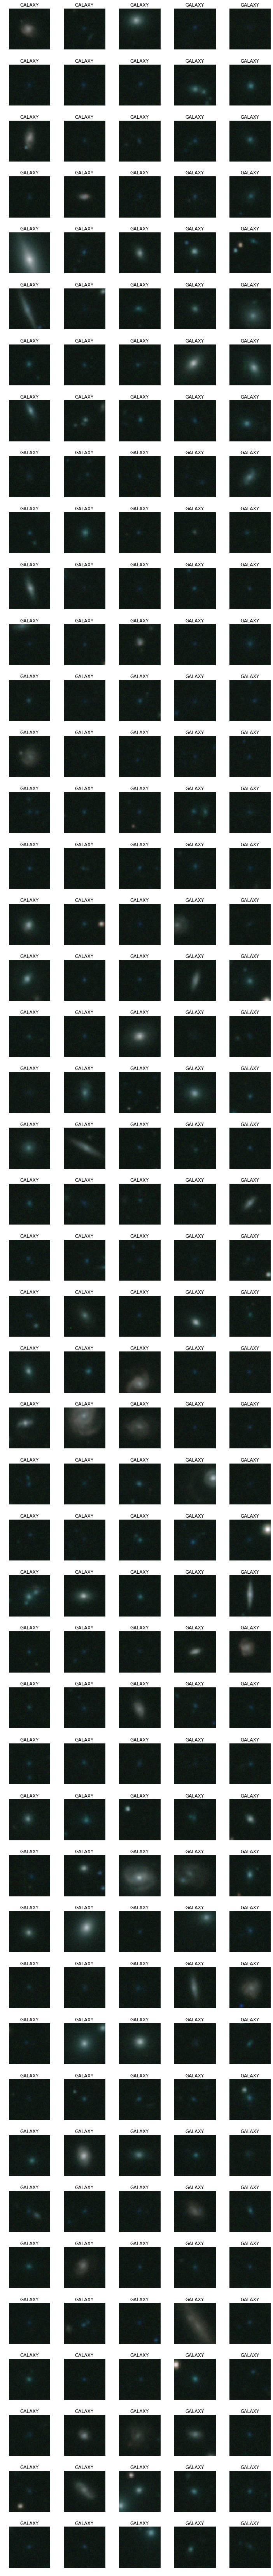

In [30]:
size = 48

cutouts = os.listdir("../data/result28")
ncol = 5
nrow = len(cutouts) // 5
np.random.shuffle(cutouts)
cutouts = cutouts[: ncol * nrow]

fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 2))
fig.tight_layout()

rgb = np.zeros((nrow * ncol, size, size, 3))
for i, f in enumerate(cutouts):
    fpath = os.path.join("../data/result28", f)
    cutout = np.load(fpath)
    rgb[i, :, :, :] = np.rollaxis(cutout[1:4, :, :], 0, 3) # 1:4 for "gri" in "ugriz"

for j in range(3):
    v = rgb[:, :, :, j]
    rgb[:, :, :, j] = (v - v.min()) / (v.max() - v.min()) * 255

# invert values so that the background is black
rgb = 255 - rgb.astype(np.uint8)

for i, f in enumerate(cutouts):
    row, col = i // ncol, i % ncol
    ax[row, col].imshow(rgb[i, :, :, :], interpolation="nearest")
    ax[row, col].axis("off")
    ax[row, col].set_title(f.split(".")[0])